# <p style="text-align:center">Lecture 4. E-Cell4における空間</p>

<p style="text-align:center;font-size:150%;line-height:150%">海津一成</p>

In [1]:
%matplotlib inline
from ecell4 import *
from ecell4_base.core import *
from ecell4_base import *

In [2]:
import seaborn
seaborn.set(font_scale=1.5)

In [3]:
import matplotlib as mpl
# mpl.rc("figure", figsize=(8.0, 5.5))
mpl.rc("figure", figsize=(6, 4))

In [4]:
from numpy import pi

## E-Cell4における空間

前回はE-Cell4における3つの要素`Model`、`World`、`Simulator`について説明した。また、常微分方程式ソルバである`ode`と確率論的手法である`gillespie`を用いて簡単な計算を試した。

`ode`や`gillespie`で計算を行なう際には容積を与えて`World`を作成したがE-Cell4における空間の取り扱いはどのようなものだろうか？

In [5]:
w1 = ode.World(ones())
w2 = gillespie.World(ones())

`ode`と`gillespie`では上の例のように一辺が1の立方体の中で計算を行ったが実際にはその容積しか問題ではない。つまり、

In [6]:
w3 = ode.World(Real3(2, 0.5, 1))  # is almost equivalent to 'w1'
w4 = gillespie.World(Real3(2, 2, 0.25))  # is almost equivalent to 'w2'

としても結局容積として1を与えるので同じ計算結果を示すだろう。

これは実際試験管内のように十分に攪拌され、空間的に均一な系では妥当に思える。

しかしながら、細胞内は明かに空間的に一様とは言えない。こうした分子の局在を考慮するためには空間を考慮した生化学計算が必要である。

E-Cell4では様々な空間表現やそれに対応した計算技法が利用可能である。

以下ではまずその内の1つである空間Gillespie法を例にE-Cell4における空間の取り扱いについて見ていく。

## 空間Gillespie法

E-Cell4で空間Gillespie法は`meso`モジュールに含まれている。まずは何も考えずに初級編で見たように`run_simulation`を用いて計算してみよう。

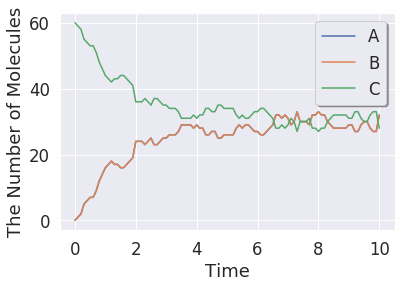

In [7]:
with reaction_rules():
    A + B == C | (0.01, 0.3)

run_simulation(10, {'C': 60}, solver='meso')

`ode`や`gillespie`に比べて幾分時間がかかったかもしれないがほぼ同じ結果が得られるだろう。`meso`モジュールは空間の設定を加えなければ`gillespie`とほとんど等価な計算を行う。

`run_simulation`を展開してみると、

In [8]:
with reaction_rules():
    A + B == C | (0.01, 0.3)

m = get_model()

In [9]:
w = meso.World(ones(), Integer3(1, 1, 1))  # XXX: Point3
w.bind_to(m)  # XXX: Point1
w.add_molecules(Species('C'), 60)

sim = meso.Simulator(w)  # XXX: Point2
sim.run(10)

使うものが`meso.World`、`meso.Simulator`になった以外はほとんど同じであるが、いくつか新しい要素がある。

1. まず、`w.bind_to(m)`ではWorldにModelを関連付けている。前回はこれをせずに済ませたが、空間的技法では`Species`の属性が非常に重要となるので忘れないようにしよう。
1. その代わりに`meso.Simulator`には`World`だけを与えれば十分である。
1. 次に重要な違いとして`meso.World`を作る際に、2つ目の引数として`Integer3(1, 1, 1)`を与えている。

最後の点は`ode.World`や`gillespie.World`ではみられなかったものだ。これが何かを説明する前にとりあえず変更してどうなるか試してみよう。

In [10]:
w = meso.World(ones(), Integer3(4, 4, 4))  # <- Integer3(1, 1, 1)

（中略）

In [11]:
w.bind_to(m)
w.add_molecules(Species('C'), 60)

sim = meso.Simulator(w)
obs = FixedIntervalNumberObserver(0.1, ('A', 'C'))
sim.run(10, obs)

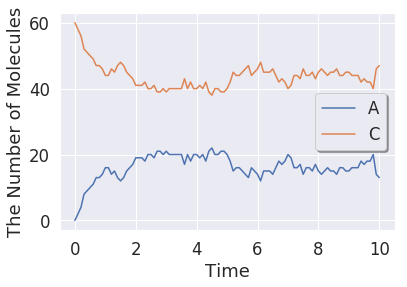

In [12]:
show(obs)

先程や`ode`、`gillespie`などとは違う結果が得られた。数字を大きくすれば結果の違いもより顕著になる。

実はこの2つ目の引数は空間の分割数を表している。

`meso`は`gillespie`とほぼ同じであるが、`gillespie`が1つの均一な閉じた空間の中で計算を行っているのに対して、`meso`は空間をSubvolumeと呼ばれる小さな直方体に分割し、それぞれのSubvolumeが異なる分子濃度を持つことを許す。

従って先程の`Integer3(4, 4, 4)`を用いた例では、一辺が1の立方体を一辺が0.25の立方体64個に分割する。

<center><img src="images/Figure4-1.png" width=600 /></center>

最初に分子種`C`を60個投入しているから、1つのSubvolume当り高々1個程度の`C`が含まれることになる。

`C`の濃度は最初の場合と同じだが、かい離した後の`A`の濃度が異なる。かい離したばかりの1つの`A`分子の濃度は、元々は$1/1=1$であったが、Subvolumeでは$1/(1/64)=64$となってしまう。結果として結合する反応が速くなるため、上のように結合状態`C`の量が多くなる。

別の見方で説明しよう。

`meso`ではかい離直後の`A`と`B`は必ず同じSubvolume内にいる。一方、`gillespie`では十分に攪拌された均一な系を仮定しているので、かい離直後の`A`と`B`分子は64つのSubvolumeのいずれかに含まれることになる。このとき`A`と`B`が同じSubvolumeに含まれる確率は1/64である。従ってやはり結合する確率が高くなる。

## 分子の拡散

なぜこのような違いが生じてしまうかと言えば、`meso`を使うことで空間を考慮したが、まだ分子の拡散運動を考えていないからだ。

これを設定するには、分子種`Species`の属性値`D`を使う。

前回は`add_species_attribute`を使ったがここでもE-Cell4の特殊記法が利用できる。

In [13]:
with species_attributes():
    A | {'D': 1}
    B | {'D': 1}
    C | {'D': 1}

    # A | B | C | {'D': '1'}  # means the same as above

`species_attributes()`を使って拡散係数を意味する`D`を`'1'`に設定した。

再度計算してみると、

In [14]:
with reaction_rules():
    A + B == C | (0.01, 0.3)

m = get_model()
w = meso.World(ones(), Integer3(4, 4, 4))  # <- Integer3(1, 1, 1)
w.bind_to(m)
w.add_molecules(Species('C'), 60)

sim = meso.Simulator(w)
obs = FixedIntervalNumberObserver(0.1, ('A', 'C'))
sim.run(10, obs)

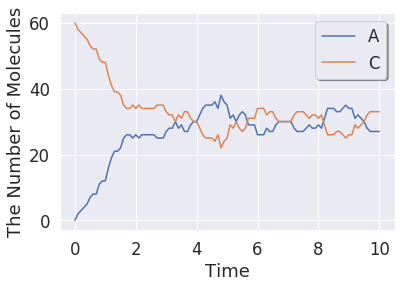

In [15]:
show(obs)

前回よりも計算に時間がかかるが、`gillespie`のときと似た結果が再び得られる。

では分子の拡散運動によってなぜ前回の問題が解決されるのだろうか?

拡散係数が$D$の分子の3次元空間における自由な拡散運動について考えよう。

拡散係数の単位は$\mathrm{\mu m}^2/s$や$\mathrm{nm}^2/\mu s$のように長さの二乗を時間で割ったものとなる。

このとき、最初の位置から時間$t$秒後の位置までの距離の二乗は平均すると$6Dt$に等しいことが知られている（平均二乗距離: Mean Squred Displacement）。

逆に言えば、長さのスケールが$l$の空間に分子が留まっている平均的な時間のスケールはおよそ$l^2/6D$程度である。

先ほどの例では、Subvolumeの一辺は0.25で拡散係数は1だから、だいたい0.01秒となる。

対して、AとB分子が同じSubvolume内にいても反応するのにかかる時間はだいたい1.5秒であるから、同じSubvolume内にかい離してもほとんどの場合反応よりも先に拡散して他のSubvolumeへと移ってしまうわけである。lが小さくなればなるほどSubvolumeの容積$l^3$は小さくなり、従ってかい離後の反応速度は高くなるが、一方で拡散によってその空間から抜け出すのにかかる時間も小さくなる。

## 分子の局在

これまでWorldへ分子を加えるのには`ode`や`gillespie`と同じように`add_molecules`関数を用いてきた。

これに対して`meso.World`ではその空間表現に応じた分子の配置が可能になる。

In [16]:
w = meso.World(ones(), Integer3(3, 3, 3))
w.bind_to(m)
w.add_molecules(Species('A'), 120)
w.add_molecules(Species('B'), 120, Integer3(1, 1, 1))

`meso.World`の`add_molecules`では3つ目の引数として`Integer3`を1つだけ与えることでどのSubvolumeにその分子を配置するかを指定することができる。

先の例では分子種`A`は空間全体にちらばるが、`B`はちょうど中心のSubvolumeだけに配置される。

このことを確かめるには`num_molecules`を使えば良い。

In [17]:
print(w.num_molecules(Species('B')))  # total
print(w.num_molecules(Species('B'), Integer3(0, 0, 0)))
print(w.num_molecules(Species('B'), Integer3(1, 1, 1)))

120
0
120


次に、より直感的に分子の局在を把握するために分子の配置を可視化してみよう。

In [18]:
viz.plot_world(w, radius=0.01)

`viz.plot_world`は`World`を与えることでJupyter Notebook上で粒子の配置をインタラクティブに可視化してくれる。 引数`radius`で分子の大きさを指定している。

この分子の初期配置をもとにしてシミュレーションを行なってみると、1秒後には

In [19]:
sim = meso.Simulator(w)
sim.run(1)

In [20]:
viz.plot_world(w, radius=0.01)

## 分子の初期配置と反応

分子の局在が反応にどのような影響を持つのかを極端な例で確かめる。

In [21]:
with species_attributes():
    A | B | C | {'D': '1'}

with reaction_rules():
    A + B > C | 0.01

m = get_model()
w = meso.World(Real3(10, 1, 1), Integer3(10, 1, 1))
w.bind_to(m)

モデルは簡単な結合反応だけを含み、WorldはX軸方向に長い直方体とした。

ここに分子を偏ったかたちで配置する。

In [22]:
w.add_molecules(Species('A'), 1200, Integer3(2, 0, 0))
w.add_molecules(Species('B'), 1200, Integer3(7, 0, 0))
viz.plot_world(w, radius=0.025)

想定した配置が得られていれば`meso.Simulator`を用いて計算する。

In [23]:
obs2 = run_simulation(5, model=m, y0={'A': 1200, 'B': 1200}, volume=10, solver='gillespie', species_list=('A', 'C'), return_type='observer')

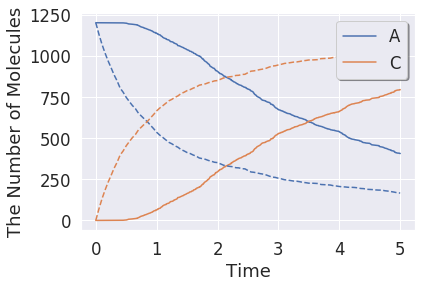

In [24]:
sim = meso.Simulator(w)
obs1 = NumberObserver(('A', 'C'))  # log after every steps
sim.run(5, obs1)
show(obs1, '-', obs2, '--')

実線が偏りがある場合（`meso`）で、点線が偏りがない（`gillespie`）場合。

偏りがある場合は明かに反応に遅れがみられる。さらによく見れば、時系列の形状も実線と点線では異なっていることに気がつくかもしれない。

これは`A`分子と`B`分子が拡散によって出会うまでに時間がかかるため。

実際、初期配置による`A`と`B`間の距離（およそ4）だけ進むのにかかる時間スケールは$4^2/2(D_\mathrm{A}+D_\mathrm{B})=4$秒である.

## Spatiocyteによる1分子粒度シミュレーション

空間Gillespie法を用いてE-Cell4における空間表現の一例を説明してきた。次に、より高解像度な空間表現である**1分子粒度計算**について見ていこう。

### 微視格子法Spatiocyte

空間Gillespie法では、Gillespie法より小さな空間に分割し、Subvolume間での分子の拡散を考えた。

いずれにせよ分子は個数だけが扱われ、各分子の位置というのは不確定である。言い換えれば、この計算手法の空間的解像度はSubvolumeの一辺$l$に等しい。

解像度を高めるには$l$を小さくすれば良いが、この手法では$l$は分子の直径$R$に対して十分大きく（少くとも10倍以上）なければならない。

では, 空間解像度を分子の大きさまで高めるにはどうすれば良いだろうか？

その答えとして、分子を何個あるかではなく、位置をもった各分子の反応拡散運動を直接表現した1分子粒度シミュレーションが挙げられる。

E-Cell4では複数の1分子粒度計算技法が利用できるが、ここでは微視格子法Spatiocyteを例にとって説明する。

Spatiocyteは各分子を1個の反応する剛体球とみなして、六方最密格子で表現された空間中を動かす。

<center><img src="images/Figure4-2.png" width=300 /></center>

各々の分子には識別番号`ParticleID`がふられ、その分子の位置を分子大の粒度で扱える。
時間スケールでは、空間Gillespie法に比べて100倍程度細かい。

Spatiocyteを使ってみよう。

In [25]:
with species_attributes():
    A | B | C | {'D': 1}

with reaction_rules():
    A + B == C | (0.01, 0.3)

m = get_model()

w = spatiocyte.World(ones(), 0.01)
w.bind_to(m)
w.add_molecules(Species('C'), 60)

sim = spatiocyte.Simulator(w)
sim.run(10)

違いは`spatiocyte.World`に与えられた2つ目の引数で、これはVoxel半径と呼ばれている。

In [26]:
w = spatiocyte.World(ones(), 0.01)

Spatiocyteでは分子大に分割した空間の最小単位をVoxelと呼び, その大きさがVoxel半径でである。

ほとんどの場合、これは分子の大きさとすれば良い。この例では、一辺が1$\mathrm{\mu m}$の空間中で分子の半径を10$\mathrm{nm}$とした。

### 1分子の拡散運動

1分子粒度計算を確かめるために実際に1分子を扱ってみる。

In [27]:
with species_attributes():
    A | {'D': 1}

m = get_model()
w = spatiocyte.World(ones(), 0.005)
w.bind_to(m)

pid = w.new_particle(Species('A'), 0.5 * ones())

`new_particle`関数は`spatiocyte.World`に1つの分子を指定した場所に置く。

作った分子の識別番号`pid`を返す（既に分子が置かれているなどで生成に失敗した場合は`None`を返す）。

粒子`p`には分子の位置や分子種、半径、拡散係数といった情報が含まれている。今後は識別番号`pid`を使うことで粒子`p`を取り出せる。

In [28]:
pid, p = w.get_particle(pid)
print(p.species().serial())
print(p.radius(), p.D())
print(tuple(p.position()))

A
0.005 1.0
(0.49806291436591293, 0.49652123150307814, 0.5)


`get_particle`関数は識別番号を受け取り、識別番号と粒子を返す。位置が指定した場所からずれているのは、分子を格子上にしか配置できないからである。`spatiocyte.World`は指定した場所から一番近い格子上に分子を置く。

`viz.plot_world`で可視化すると確かに中心に1分子だけが配置されている。

In [29]:
viz.plot_world(w)

この分子の拡散の軌跡を追うためにも`Observer`が利用できる.

In [30]:
sim = spatiocyte.Simulator(w)
obs = FixedIntervalTrajectoryObserver(0.002, (pid, ))
sim.run(1, obs)
viz.plot_trajectory(obs)

`data`関数によって軌跡を`Real3`のリストとして取り出せる。

In [31]:
print(len(obs.data()))
print(len(obs.data()[0]))  # 1/0.02+1
print(tuple(obs.data()[0][0]))

1
501
(0.49806291436591293, 0.49652123150307814, 0.5)


`add_molecules`関数で追加した分子も`list_particles`で分子種から粒子をまとめて引き出せる。

In [32]:
w.add_molecules(Species('A'), 5)

particles = w.list_particles(Species('A'))
for pid, p in particles:
    print(pid.serial(), p.species().serial(), tuple(p.position()))

1 A (0.3674234614174768, 0.4185789451624787, 0.17500000000000002)
2 A (0.6450322989329036, 0.6350852961085884, 0.6900000000000001)
3 A (0.46540305112880387, 0.6004442799572108, 0.31)
4 A (0.05715476066494083, 0.44455970727601185, 0.29)
5 A (0.5552176750308537, 0.5715767664977295, 0.88)
6 A (0.7348469228349536, 0.874685657822283, 0.145)


`list_particles`関数は、`add_molecules`関数などと同様に他の`World`でも利用できる。
Spatiocyteでも1分子を扱う正式な関数は`list_voxels`で、座標は1つの整数値で表現される.

## 拡散係数と二次反応

Spatiocyteを使って二次反応と拡散速度の関係を見てみる。

In [33]:
with species_attributes():
    A | B | C | {'D': 1}

with reaction_rules():
    A + B > C | 1.0

m = get_model()

w = spatiocyte.World(Real3(2, 1, 1), 0.005)
w.bind_to(m)
w.add_molecules(Species('A'), 120)
w.add_molecules(Species('B'), 120)

obs1 = FixedIntervalNumberObserver(0.005, ('A', 'B', 'C'))
sim = spatiocyte.Simulator(w)
sim.run(0.5, obs1)

In [34]:
obs2 = run_simulation(0.5, model=m, y0={'A': 120, 'B': 120}, volume=2, return_type='observer')

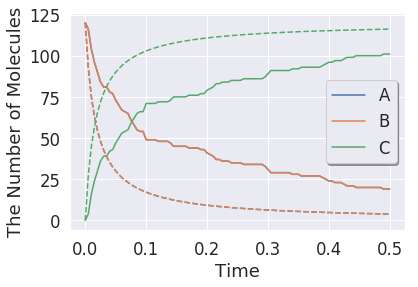

In [35]:
show(obs1, '-', obs2, '--')

今までよりも速度定数が高いが、同様の結果が得られる。しかし、常微分方程式と比較すると結果が異なる（実線が`spatiocyte`、点線が`ode'）。

### 巨視的な反応速度定数と微視的な反応速度定数

速度定数をさらに高い値にすると、`ode`では反応速度ははやまるが、`spatiocyte`ではほとんど速くならない。

- これまでのソルバは巨視的なmacroscopicもしくは実効的なeffective反応速度定数を用いる。
- 1分子粒度シミュレーションでは微視的なmicroscopicもしくは内在的なintrinsic反応速度定数を用いる。

- 巨視的な反応速度定数は分子を混ぜ合わせたときに反応の起こる速さを表す。
- 微視的な反応速度定数とは**分子が衝突したとき**にどの程度の反応性があるかを表す。

微視的な見方では反応する前にまず衝突しなければならない。

Spatiocyteではこの微視的な速度定数を速くしても拡散による衝突の速さ以上に速く反応させることはできない。
こうした状況を**拡散律速**と呼ぶ。

この巨視的な速度定数$k_\mathrm{on}$と微視的な速度定数$k_a$の間には三次元空間で以下の関係が知られている（Smoluchowski–Collins–Kimballの式）。

$${\frac{1}{k_\mathrm{on}}=\frac{1}{k_a}+\frac{1}{4\pi RD_\mathrm{tot}}}$$

ここで$R$は衝突する二つの分子の半径の和、$D_\mathrm{tot}$は拡散係数の和である。

良く攪拌された系を仮定する（拡散係数が無限）常微分方程式やGillespie法と違い、1分子粒度計算では分子の拡散と反応がきちんと分離できる。

ただし、微視的速度定数$k_a$が衝突速度$k_D{\equiv}4\pi RD_\mathrm{tot}$に対して十分小さければ巨視的速度定数とほとんど一致する（**反応律速**）。

### Smoluchowski–Collins–Kimballの式の確認

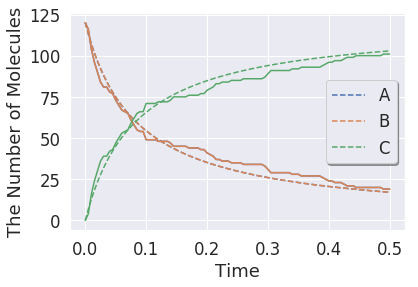

In [36]:
kD = 4 * pi * 0.01 * 2
ka = 1.0
kon = ka * kD / (ka + kD)

with reaction_rules():
    A + B > C | kon

run_simulation(0.5, y0={'A': 120, 'B': 120}, volume=2, opt_args=('--', obs1, '-'))

## Spatiocyteにおける構造体

細胞質や核、細胞膜などの構造を構造体と呼び、分子の拡散を制限するために用いる。
例えば、球状の構造体であれば、

In [37]:
w = spatiocyte.World(ones(), 0.005)
obj = Sphere(0.5 * ones(), 0.45)
w.add_structure(Species('C'), obj)
viz.plot_world(w)

球ができたところで、この球の中だけを動き回る分子を作る。そのためには`location`属性を指定する。

In [38]:
with species_attributes():
    A | {'D': 1, 'location': 'C', 'dimension': 3}
    C | {'dimension': 3}

m = get_model()

あとはいつもと同様に分子を`add_molecules`すれば良い。

In [39]:
w.bind_to(m)
w.add_molecules(Species('A'), 120)

`A`は構造体`C`上にあるとしたので`add_molecules`でも球体内に配置される。注意点として`A`を加えるよりも前に構造体を作ること。

この分子種`A`の運動が本当に球体内に制限されているかを確認してみよう。これにもやはり`FixedIntervalTrajectoryObserver`が使える。

In [40]:
pid_list = [pid for pid, p in w.list_particles(Species('A'))[: 10]]
obs = FixedIntervalTrajectoryObserver(1e-3, pid_list)
sim = spatiocyte.Simulator(w)
sim.run(1, obs)
viz.plot_trajectory(obs)

### 構造体と反応

構造体間の分子の移行について説明する。平面を例にとって試す。

まず平面を作るには原点`origin`と二つの軸ベクトル`unit0`、`unit1`の3つの`Real3`を用いる。

In [41]:
origin = Real3(0, 0, 0.5)
unit0 = unitx()  # Real3(1, 0, 0)
unit1 = unity()  # Real3(0, 1, 0)
obj = PlanarSurface(origin, unit0, unit1)

これを利用して平面上の分子種`A`と通常の分子種`B`を想定すると、

In [42]:
with species_attributes():
    A | {'D': 0.1, 'location': 'M', 'dimension': 2}
    B | {'D': 1, 'dimension': 3}
    M | {'dimension': 2}

with reaction_rules():
    B + M == A | (0.1, 0.2)

m = get_model()

`B`分子が構造体`M`と衝突して吸着、`A`分子となる。逆にまた`A`分子はかい離してもとの平面と`B`分子になる。

初期配置では`location`属性を持たない`B`はどの構造体にも属さず、一様に分布している。

In [43]:
w = spatiocyte.World(ones())
w.bind_to(m)
w.add_structure(Species('M'), obj)
w.add_molecules(Species('B'), 480)
viz.plot_world(w, species_list=('A', 'B'))

後はいつもと同じように計算すると、

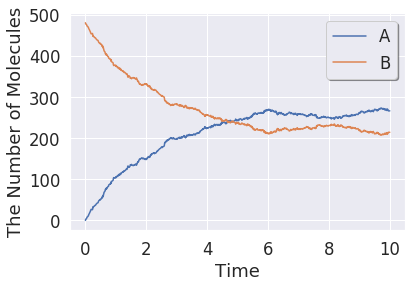

In [44]:
sim = spatiocyte.Simulator(w)
obs = NumberObserver(('A', 'B'))
sim.run(10, obs)
show(obs)

構造体`M`と反応して膜上の分子種`A`ができているのがわかる。

In [45]:
viz.plot_world(w, species_list=('A', 'B'))

ちなみに、構造体からのかい離では構造体の分子種は省略できるが、結合では省略できない。

生成物である`A`分子を配置すべき`M`がまわりに無ければかい離は不可能だからだ。

また、かい離の場合は構造体を省略してもしなくても一次反応であることに変わりないが、結合はあくまでも二次反応であり、速度定数の単位も一時反応とは異なる。

In [46]:
with reaction_rules():
    B + M > A | 1e-3
    A > B | 3.0  # means the same as A > B + M

In [47]:
get_model()

## 練習問題

- **空間Gillespie法に関する練習**: 空間Gillespie法で一辺が$l$のSubvolumeの場合について拡散の時間スケールを計算した。一方でかい離直後の分子が再び結合するのにかかる時間スケールについても説明した。この2つの時間スケールの$l$に対する依存性について考え、$l$が満足すべき条件について明かにする。ただし、空間Gillespie法では$l$について下記の条件を満すべきことが知られている。
  
  $${R^2 \ll l^2 \ll 6D\tau_\mathrm{min}}$$
  
  ここで, $R$は分子の直径 (より正確には反応半径), $\tau_\mathrm{min}$は分子の各反応に対するもっとも短かい平均寿命shortest life-timeを表わす。
  
  Elf J. and Ehrenberg M., Syst. Biol., 1(2), 230-236 (2004)

- **分子の初期配置に関する練習**: 上の例を改変して、`AB`分子の初期配置、反応速度定数や拡散係数といったパラメータを様々に変えて反応にどのような影響があるか調べる。また、空間均一なGillespie法を使って上の例のような時系列を再現するモデルを作ることができないだろうか？

- **分子の拡散に関する練習**: 三次元における自由拡散の場合、拡散係数$D$の分子の$t$秒後の位置までの平均二乗距離は

  $$\left\langle L^2\right\rangle = 6Dt$$

  となることが知られている。実際Spatiocyteでもそうなっているだろうか？

- **巨視的と微視的速度定数に関する練習**: 巨視的にせよ微視的にせよ速度定数の単位は同じ$\mathrm{nM}^{-1}s^{-1}$や$\mathrm{\mu m}^3s^{-1}$である。拡散速度が1$\mathrm{\mu m}^2/s$で、直径が5$\mathrm{nm}$の二つの分子の衝突速度定数$k_D$は何$\mathrm{nM}^{-1}s^{-1}$であるか？

- **構造体に関する練習**: 平面の構造体を使って、平面上での拡散係数$D$とその平均二乗距離の関係について確かめる。また、球上ではどう考えたらよいか？